# Prophet baseline

Facebook released prophet 2 years ago and managed to create a better user experience, with easy customizability and performace boost, both in excecution time and in accuracy. The library is based on Stan, a state-of-the-art statistical modeling and computation platform.

In [20]:
import numpy as np
import pandas as pd  
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [21]:
# Load clean
data = pd.read_csv('../data/interim/trips_per_hour_dropped_na_and_all_outliers_under_001_and_over_999.csv')
data.request_date = pd.to_datetime(data.request_date)
# ts = raw_pd.set_index(raw_pd.request_date)['trip_counts']
# ts_df = pd.DataFrame(ts)
data

request_date  trip_counts
0    2015-09-01 00:00:00      705.000
1    2015-09-01 01:00:00      476.000
2    2015-09-01 02:00:00      489.000
3    2015-09-01 03:00:00      559.000
4    2015-09-01 04:00:00      353.000
...                  ...          ...
2900 2015-12-30 20:00:00      532.000
2901 2015-12-30 21:00:00      587.000
2902 2015-12-30 22:00:00      703.000
2903 2015-12-30 23:00:00     1171.000
2904 2015-12-31 00:00:00       20.424

[2905 rows x 2 columns]

In [22]:
# Required by prophet
fb_ts = data
fb_ts['ds'] = data.request_date.copy()
fb_ts['y'] = data.trip_counts.copy()


#### Simple train-test split

In [23]:
from pmdarima.model_selection import train_test_split

train_len = int(len(fb_ts)*.99)
test_len = len(fb_ts) - train_len
y_train, y_test = train_test_split(fb_ts, train_size=train_len)

train_len, test_len

(2875, 30)

In [24]:
from fbprophet import Prophet

In [25]:
m = Prophet()
m.fit(y_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [26]:
future = m.make_future_dataframe(periods=30, freq='H')
future.tail()

ds
2900 2015-12-30 20:00:00
2901 2015-12-30 21:00:00
2902 2015-12-30 22:00:00
2903 2015-12-30 23:00:00
2904 2015-12-31 00:00:00

In [27]:
forecast = m.predict(future)
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
2900 2015-12-30 20:00:00  1431.632812   359.046652  2201.849721  1431.632812   
2901 2015-12-30 21:00:00  1432.506606   485.325108  2386.113356  1432.506606   
2902 2015-12-30 22:00:00  1433.380400   781.827235  2769.372612  1433.380400   
2903 2015-12-30 23:00:00  1434.254194  1144.466479  3040.268358  1434.254194   
2904 2015-12-31 00:00:00  1435.127988  1332.005516  3148.541656  1435.127873   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
2900  1431.651716     -221.280504           -221.280504           -221.280504   
2901  1432.536400      -53.117958            -53.117958            -53.117958   
2902  1433.419823      294.942314            294.942314            294.942314   
2903  1434.317951      660.385140            660.385140            660.385140   
2904  1435.217361      800.625643            800.625643            800.625643   

           daily  daily_lower  daily_upper     weekly  weekly_lower  \
2900 -232.603013  -232.603013  -232.603013  11.322509     11.322509   
2901  -63.653353   -63.653353   -63.653353  10.535395     10.535395   
2902  285.328854   285.328854   285.328854   9.613460      9.613460   
2903  651.781309   651.781309   651.781309   8.603831      8.603831   
2904  793.069343   793.069343   793.069343   7.556300      7.556300   

      weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
2900     11.322509                   0.0                         0.0   
2901     10.535395                   0.0                         0.0   
2902      9.613460                   0.0                         0.0   
2903      8.603831                   0.0                         0.0   
2904      7.556300                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
2900                         0.0  1210.352309  
2901                         0.0  1379.388648  
2902                         0.0  1728.322715  
2903                         0.0  2094.639335  
2904                         0.0  2235.753632

<IPython.core.display.Javascript object>


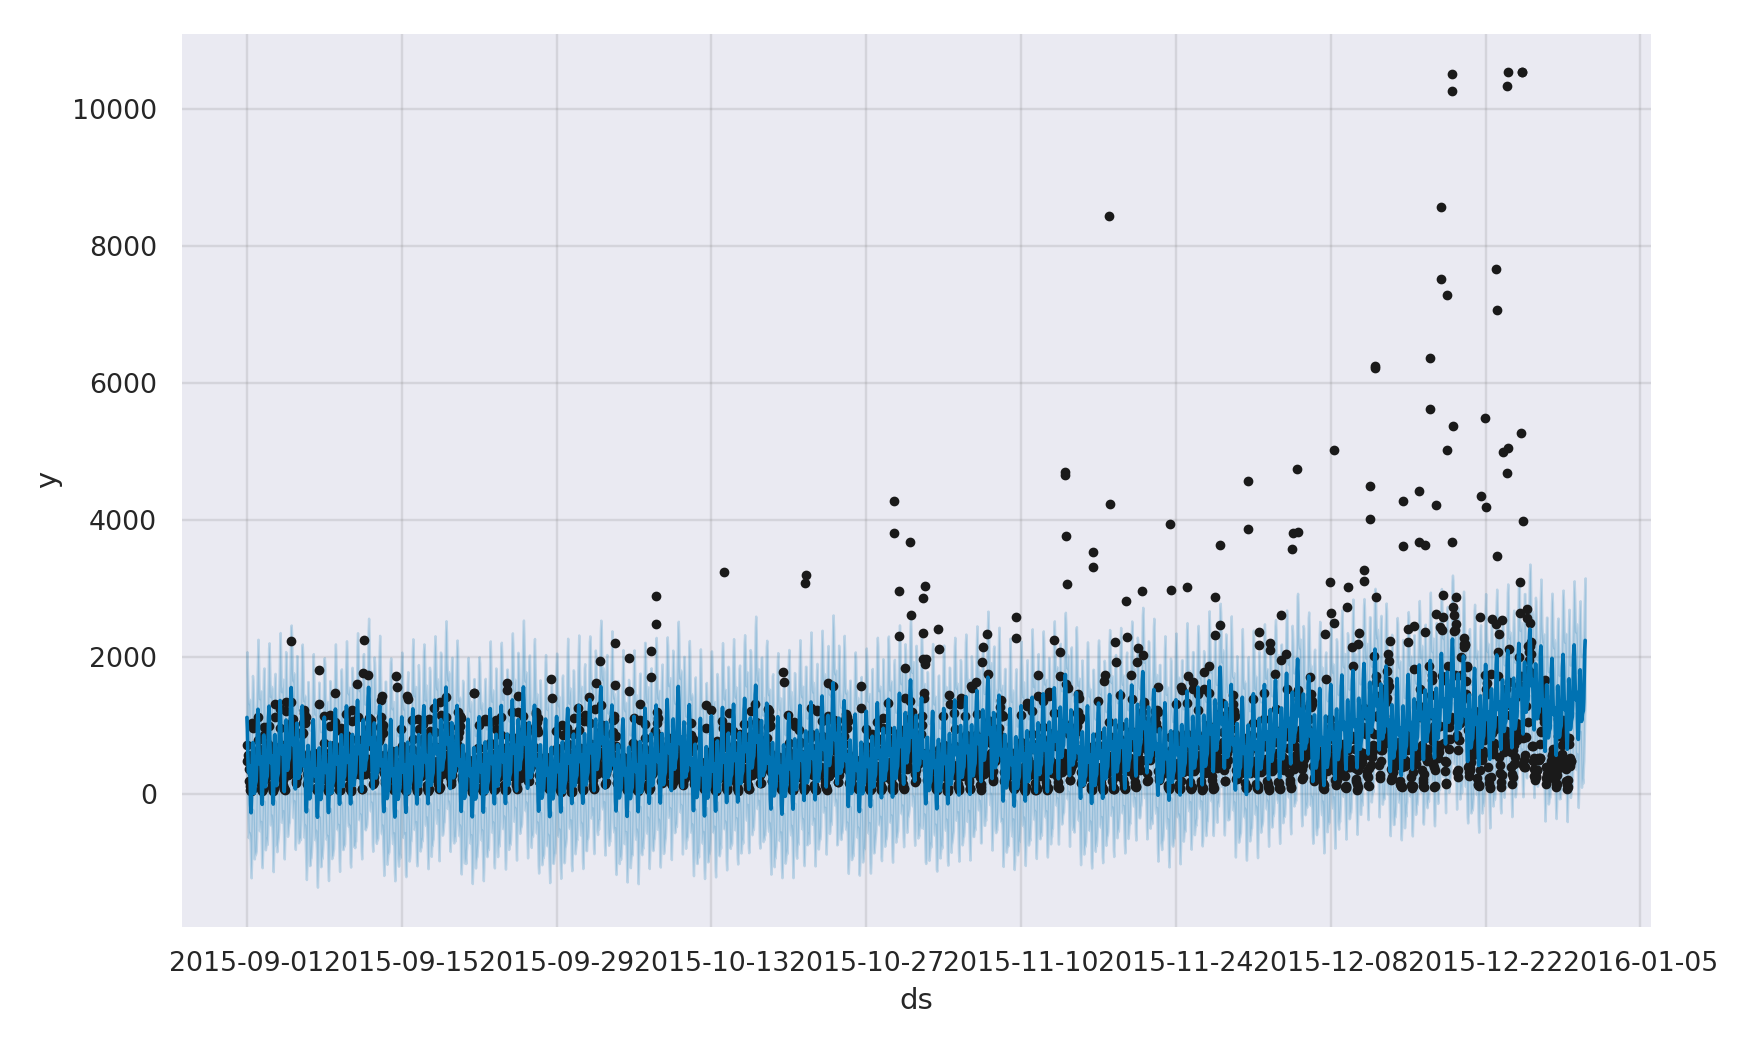

In [28]:
m.plot(forecast)
plt.show()

## Components

The process of decomposing the trend and seasonality is depicted below, and we can see that the trend is not dropping. We will improve this in a later iteration.

<IPython.core.display.Javascript object>


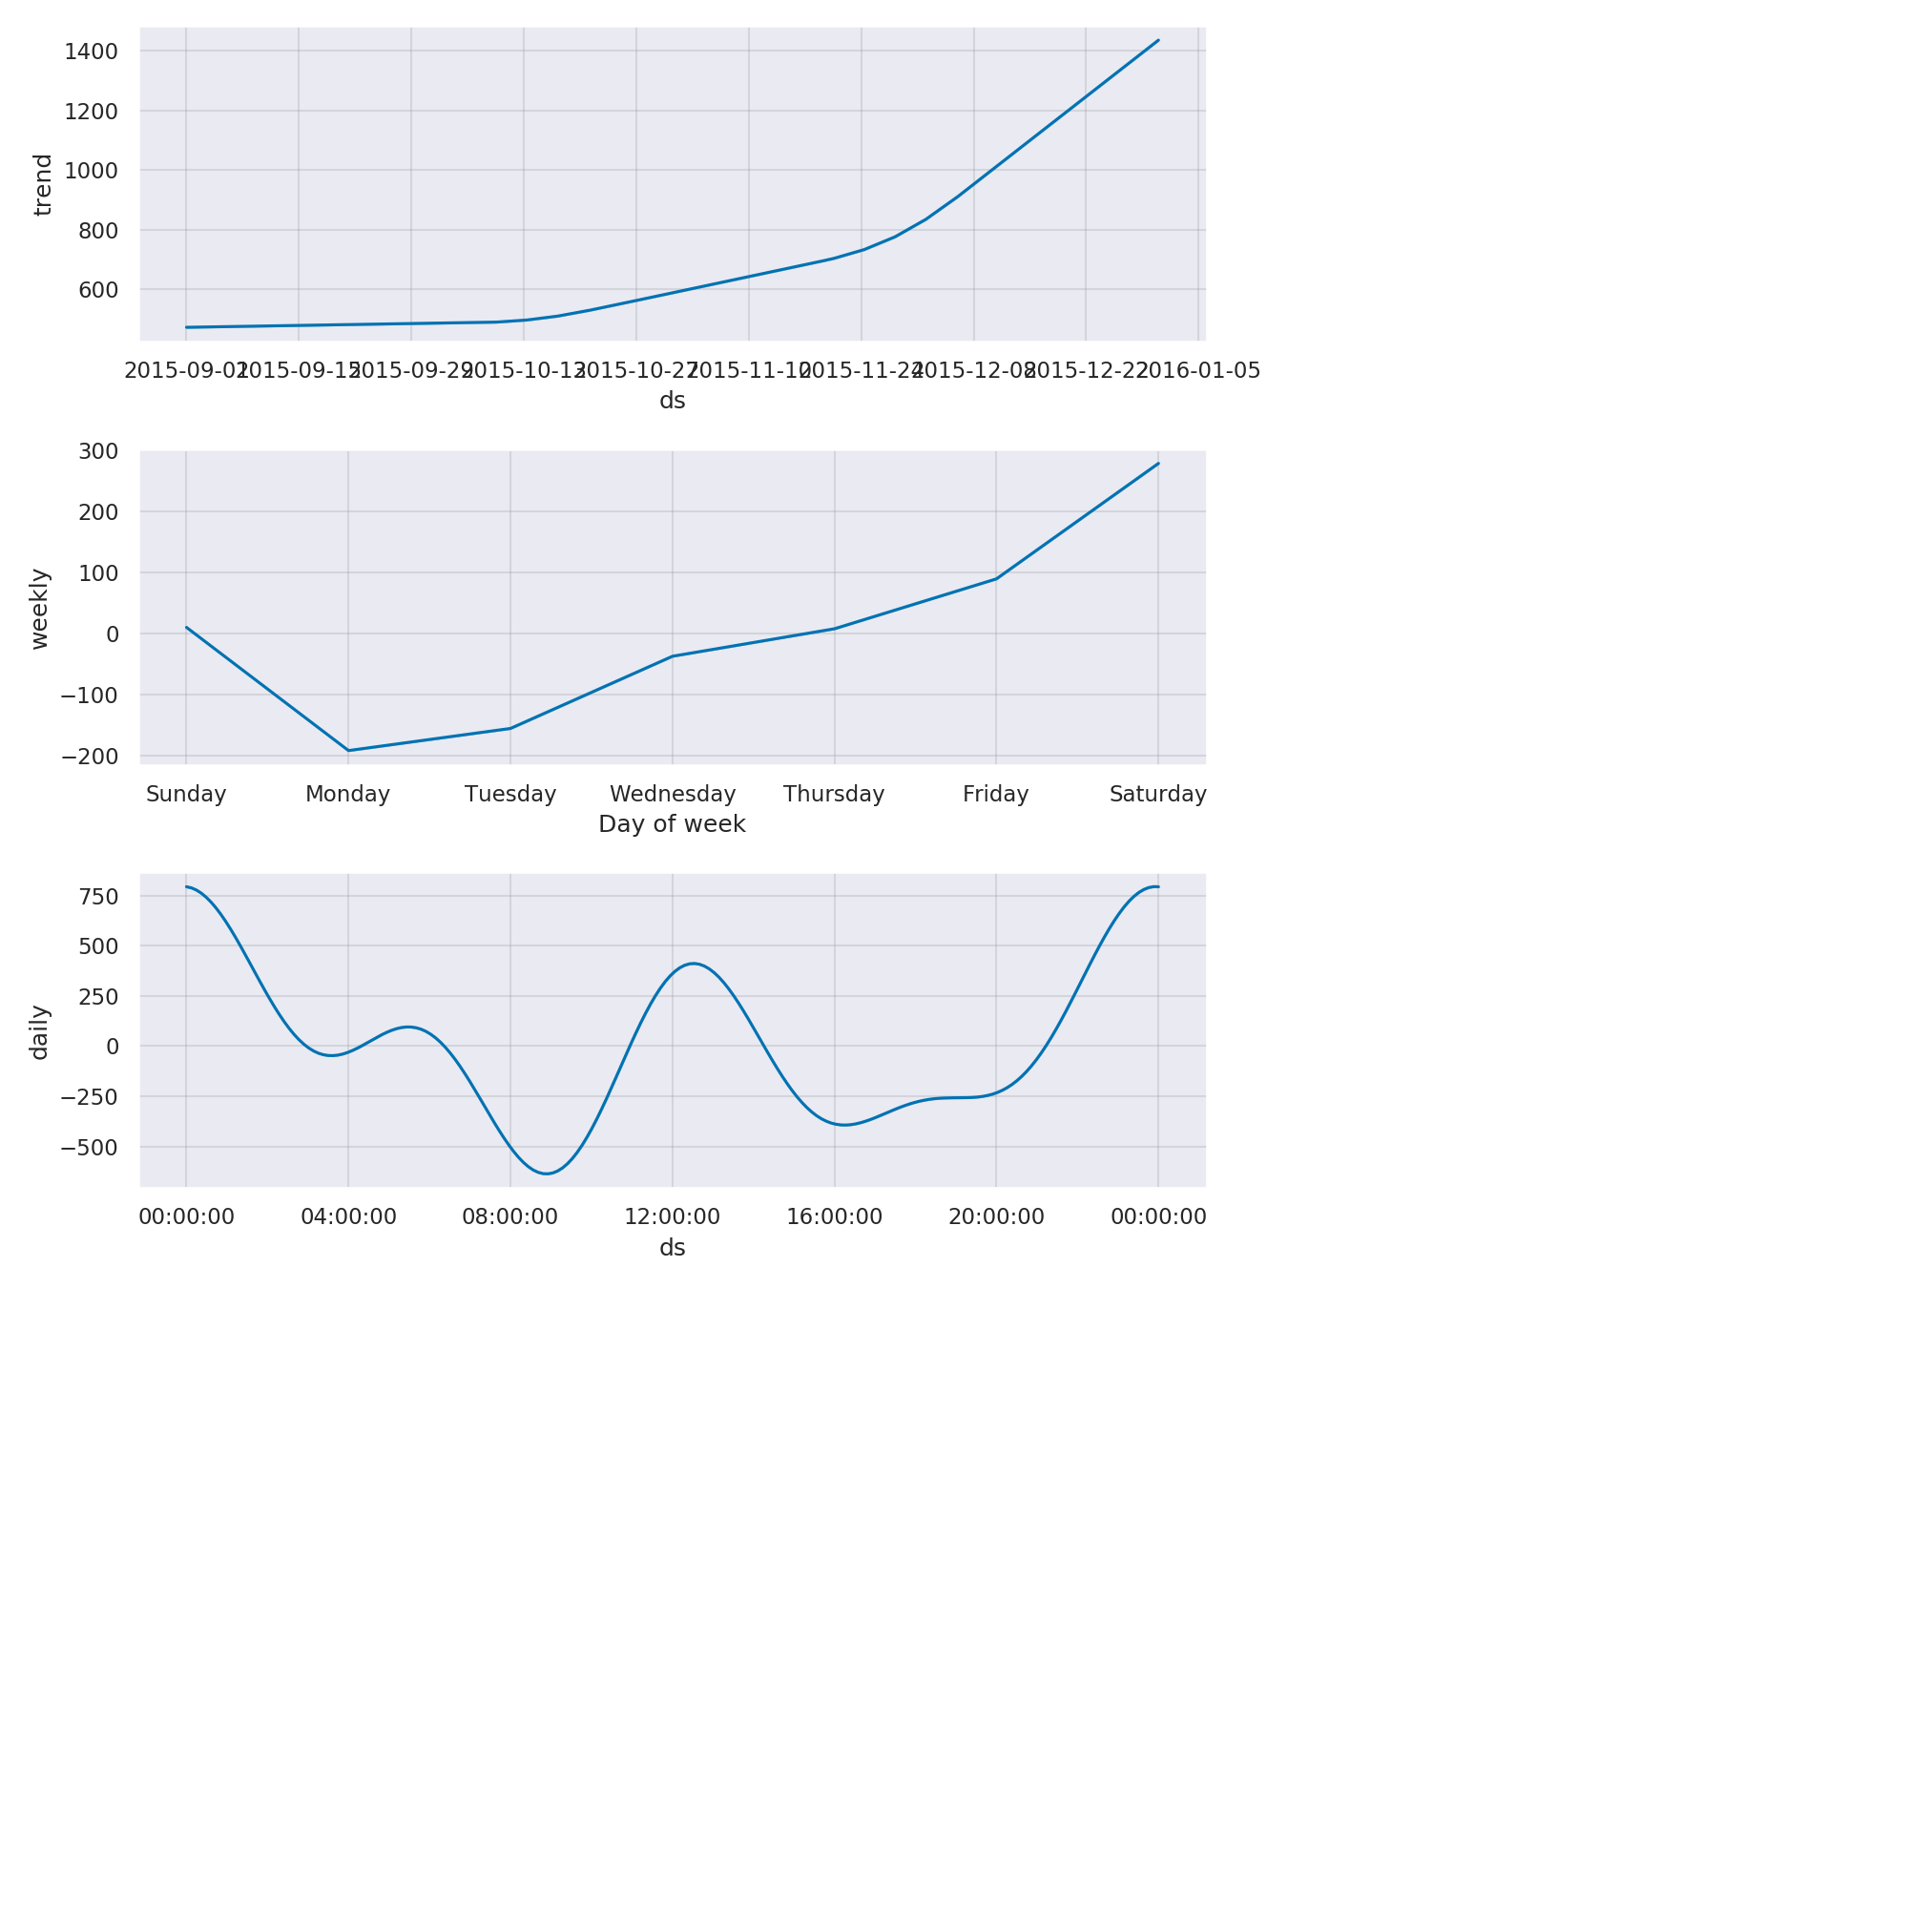

In [29]:
m.plot_components(forecast)
plt.show()

## Closer examination with Plotly

A more interactive view is provided with a plotly diagram, for examination and qualitive assessment.

In [30]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

## Cross validation: 4 forecasts after an initial period of 2months

In [31]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='60 days', period='15 days', horizon = '5 days')
df_cv.head()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2015-11-09 18:00:00 and 2015-12-24 18:00:00


ds        yhat  yhat_lower   yhat_upper       y  \
0 2015-11-09 19:00:00  378.617361  -84.809696   843.164107   275.0   
1 2015-11-09 20:00:00  424.741864   -6.203095   923.083286   376.0   
2 2015-11-09 21:00:00  521.236511   43.436606   959.587796   378.0   
3 2015-11-09 22:00:00  695.675975  231.803190  1172.798153   666.0   
4 2015-11-09 23:00:00  884.251557  402.735879  1334.886065  1146.0   

               cutoff  
0 2015-11-09 18:00:00  
1 2015-11-09 18:00:00  
2 2015-11-09 18:00:00  
3 2015-11-09 18:00:00  
4 2015-11-09 18:00:00

In [32]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse         mae      mape  coverage
0 12:00:00  2.192796e+06  1480.809396  653.593404  0.666913  0.770833
1 13:00:00  3.901657e+06  1975.261354  849.910075  0.889973  0.750000
2 14:00:00  4.057815e+06  2014.401851  898.866527  0.987344  0.729167
3 15:00:00  4.045959e+06  2011.456986  886.814790  1.147668  0.729167
4 16:00:00  4.046871e+06  2011.683661  900.939746  1.388299  0.729167

<IPython.core.display.Javascript object>


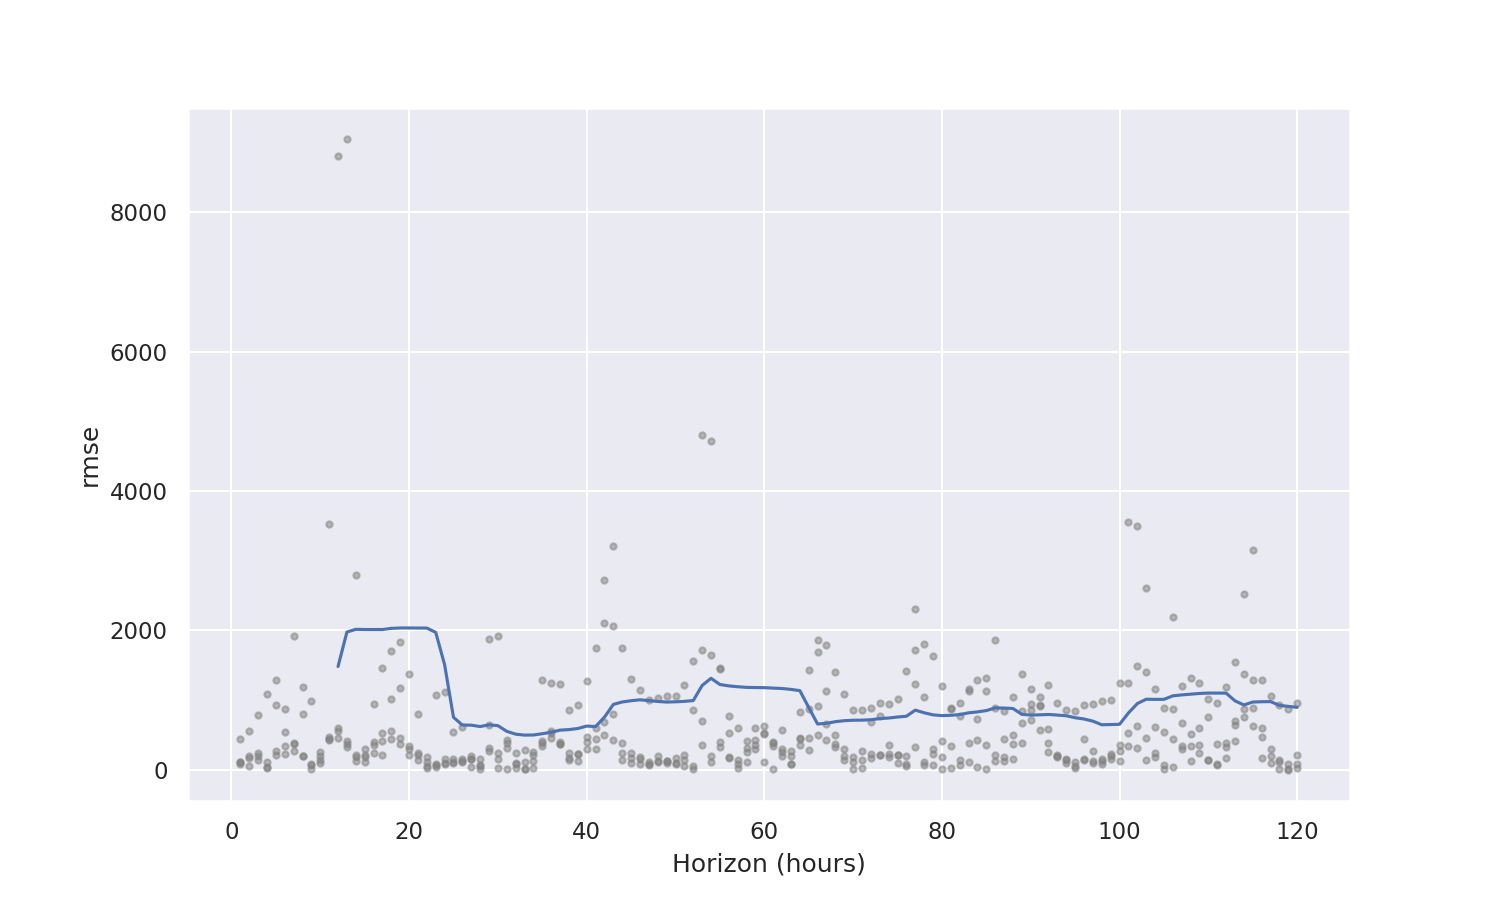

In [33]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')
fig.show()

# Conclusion

Facebook prophet has out of the box provided a very good result, both in showing a notion of trend and an understanding of seasonality. Moreover the streamlined interface and toolchain create a superb experience. We will see if we can improve the results in a following notebook.